# **Random Forest**


- Import libraries and load data.

In [15]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier 
from sklearn.metrics import mean_squared_error

# Data
X_train_df = pd.read_csv('../data/gold/X_train_df.csv', index_col='respondent_id') # training set features

training_set_labels_df = pd.read_csv('../data/raw/training_set_labels.csv', index_col='respondent_id') # training set labels

X_test_df = pd.read_csv('../data/gold/X_test_df.csv', index_col='respondent_id') # test set features

submission_format_df = pd.read_csv('../data/raw/submission_format.csv', index_col='respondent_id') # submission format

### **MODELING**

- Train test split.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df, training_set_labels_df, test_size=0.2, random_state=42, stratify=training_set_labels_df)

**The Cross Validation is commented in order to avoid larger running time. Therefore, the best hyperparameters obtained are directly passed to the model**

- Model for cross validaton.

In [17]:
# # Set up the MultiOutputClassifier with Random Forest Regressor
# multi_output_clf = MultiOutputClassifier(RandomForestClassifier(random_state=42))

- Param grid for cros validation.

In [18]:
# # Let's do GridSearchCV
# # parameters grid
# param_grid = {
#     "estimator__n_estimators": [50, 100, 200],
#     "estimator__criterion" : ["gini", "entropy"],
#     "estimator__max_depth" : [None, 5, 10, 20, 30],
#     "estimator__min_samples_split" : [2, 5, 10],
#     "estimator__min_samples_leaf": [1, 2, 4],
#     "estimator__class_weight" :['balanced', 'balanced_subsample'],
#     "estimator__bootstrap" : [True, False]            # Si usar o no remuestreo (bootstrap). 
#     # class weight should be balanced or balanced_subsample - we have imbalance issue.
# }

- GridSearch for Cross Validation. Fit the model obtained with best params and then seeing results. Commented in order to avoid larger running time.

In [19]:
# # Initialize Grid Search
# grid_search = GridSearchCV(estimator=multi_output_clf, param_grid=param_grid,
#                            cv=5, n_jobs=-1, verbose=2)

# # Fit the Grid Search model
# grid_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters from Grid Search:", grid_search.best_params_)
# print("Best Score from Grid Search:", grid_search.best_score_)

# # Evaluate on the test set
# y_pred_grid = grid_search.predict(X_test)
# mse_grid = mean_squared_error(y_test, y_pred_grid)
# print(f"Mean Squared Error (Grid Search): {mse_grid}")

**Model with the best hyperparameters obtained by the Cross Validation commented above**.

In [20]:
estimators = MultiOutputClassifier(
    estimator=RandomForestClassifier(
        bootstrap=True, 
        class_weight='balanced_subsample', 
        criterion='entropy', 
        max_depth=None, 
        min_samples_leaf=2, 
        min_samples_split=2, 
        n_estimators=200, 
        random_state=42
    )
)

- Fit the model.

In [21]:
estimators.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                       criterion='entropy',
                                                       min_samples_leaf=2,
                                                       n_estimators=200,
                                                       random_state=42))

- Make predictions with the model.

In [22]:
preds = estimators.predict_proba(X_test)
preds

[array([[0.95761126, 0.04238874],
        [0.4872651 , 0.5127349 ],
        [0.89984417, 0.10015583],
        ...,
        [0.93881178, 0.06118822],
        [0.51234849, 0.48765151],
        [0.57083645, 0.42916355]]),
 array([[0.60871379, 0.39128621],
        [0.21655472, 0.78344528],
        [0.90312299, 0.09687701],
        ...,
        [0.83868435, 0.16131565],
        [0.38556662, 0.61443338],
        [0.41231429, 0.58768571]])]

- Save the predictions in a dataframe.

In [23]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:,1],
        'seasonal_vaccine':preds[1][:,1],
    },
    index=y_test.index
)
print('y_preds.shape:', y_preds.shape)
y_preds.head()

y_preds.shape: (5342, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
22317,0.042389,0.391286
1215,0.512735,0.783445
10540,0.100156,0.096877
7407,0.270520,0.423101
14697,0.245038,0.292702


### **RESULTS: ROC CURVE**

- Method to plot ROC Curve.

In [24]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0,1], [0,1], color='red', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

- Figures to show ROC Curves obtained with the predictions.

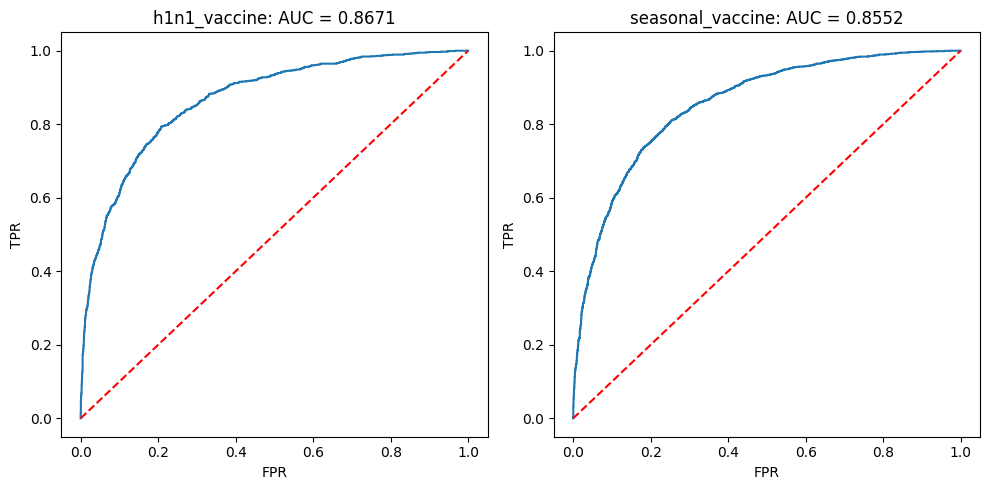

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0])

plot_roc(
    y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1])

fig.tight_layout()

### **MAKE AND SAVE THE PREDICTIONS FOR THE COMPETITION.**

- Fit the model with the training_set_labels_df for the competittion and later make the prediction.

In [26]:
estimators.fit(X_train_df, training_set_labels_df)
preds = estimators.predict_proba(X_test_df)
preds

[array([[0.77582981, 0.22417019],
        [0.97250199, 0.02749801],
        [0.65618663, 0.34381337],
        ...,
        [0.73293127, 0.26706873],
        [0.9425451 , 0.0574549 ],
        [0.39712621, 0.60287379]]),
 array([[0.66725824, 0.33274176],
        [0.97823538, 0.02176462],
        [0.17158488, 0.82841512],
        ...,
        [0.77222749, 0.22777251],
        [0.63581161, 0.36418839],
        [0.36057317, 0.63942683]])]

- Save the predictions to upload to the competition in a dataframe.

In [27]:
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:,1],
        'seasonal_vaccine':preds[1][:,1],
    },
    index=X_test_df.index
)
print('y_preds.shape:', y_preds.shape)
y_preds.head()

y_preds.shape: (26708, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
26707,0.224170,0.332742
26708,0.027498,0.021765
26709,0.343813,0.828415
26710,0.697235,0.885092
26711,0.322370,0.532642


- Export the dataframe of predictions to a CSV.

In [28]:
y_preds.to_csv('../results/pred_random_forest_output.csv', index = True)